# Data Aggregation: 5 to 30/60 minute

Prior to 2018, the 30- and 60-minute PSM3 data reflected "instantaneous" values for nominal 4 km pixels.  Starting in 2018 when higher resolution (5 minute, 2 km) GOES imagery became available, the 30- and 60-minute values switched to being spatial and temporal averages of the higher-resolution 5-minute data. 

This notebook recreates the aggregation performed to calculate the 30- and 60-minute values from the 5-minute values.

Starting with the 30-minute values, the spatial average is easy: each 4 km pixel comprises four 2 km pixels, so get data for the four constituent pixels and average them together.  The temporal average is slightly complicated in that, because the 30-minute values are symmetrical averages of seven 5-minute values, some 5-minute values contribute to two separate interval averages.  Here's an ASCII illustration of this concept:

```
Timestamps: 00 05 10 15 20 25 30 35 40 45 50 55 00 05 10 15 20 25
Interval 1:          --------------------
Interval 2:                            --------------------
```

The 5-minute value at minute `45` gets incorporated into the average for both 30-minute intervals.

Note that this method does not _perfectly_ recreate the 30-minute values, and I'm not sure that this is actually what happens in the real NSRDB.  But it does get pretty close.

In [1]:
import pvlib
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
lat, lon = 40.005, -80.005

# Be aware that `get_psm3()` uses a different endpoint for interval=5 than it does for interval=30 or 60

kwargs = dict(latitude=lat, longitude=lon, api_key='DEMO_KEY', email='assessingsolar@gmail.com',
              names='2018', map_variables=False, leap_day=True)

In [3]:
df_4km30, meta = pvlib.iotools.get_psm3(interval=30, **kwargs)
print('4 km pixel coords:', meta['Latitude'], meta['Longitude'])  # 40.01 -80.02

4 km pixel coords: 40.01 -80.02


In [4]:
df_2km1, meta = pvlib.iotools.get_psm3(interval=5, **kwargs)
print('2 km pixel coords:', meta['Latitude'], meta['Longitude'])  # 40.00 -80.01

2 km pixel coords: 40.0 -80.01


So the center of the outer 4 km pixel is North and West of the center of the inner 2 km pixel.  That means the other three inner 2km pixels in this 4 km pixel are North, West, and North-West of this one.  Since the 2 km pixels are 0.02 degrees on a side, that means stepping 0.02 degrees will get us the neighbor pixels:

In [5]:
kwargs['latitude'] = lat
kwargs['longitude'] = lon - 0.02  # one pixel west
df_2km2, meta = pvlib.iotools.get_psm3(interval=5, **kwargs)
print('2 km pixel coords:', meta['Latitude'], meta['Longitude'])  # 40.00 -80.03

2 km pixel coords: 40.0 -80.03


In [6]:
kwargs['latitude'] = lat + 0.02  # one pixel north
kwargs['longitude'] = lon
df_2km3, meta = pvlib.iotools.get_psm3(interval=5, **kwargs)
print('2 km pixel coords:', meta['Latitude'], meta['Longitude'])  # 40.02 -80.01

2 km pixel coords: 40.02 -80.01


In [7]:
kwargs['latitude'] = lat + 0.02  # one pixel north-west
kwargs['longitude'] = lon - 0.02
df_2km4, meta = pvlib.iotools.get_psm3(interval=5, **kwargs)
print('2 km pixel coords:', meta['Latitude'], meta['Longitude'])  # 40.02 -80.03

2 km pixel coords: 40.02 -80.03


Now, implement the spatiotemporal aggregation method described above.  I think this is about as clean as it gets when using pandas, but please let me know if there's a better way.

In [8]:
def aggregate30(x1, x2, x3, x4):
    avg_5min = pd.concat([x1, x2, x3, x4], axis=1).mean(axis=1)
    resampler = avg_5min.shift(3).resample('30T')
    sum_30min_6samples = resampler.sum()
    avg_30min_7samples = (sum_30min_6samples + resampler.first().shift(-1)) / 7
    return avg_30min_7samples

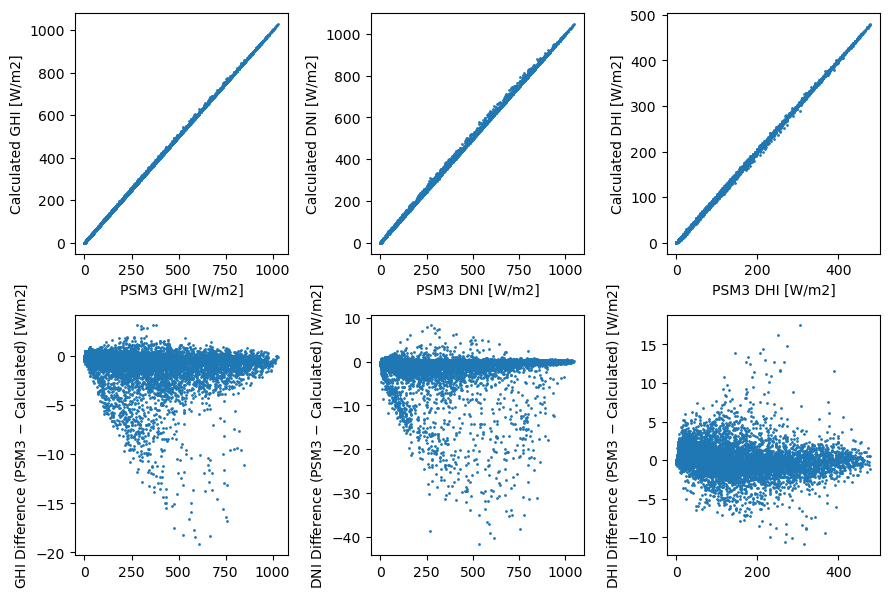

In [9]:
columns = ['GHI', 'DNI', 'DHI']
fig, axes = plt.subplots(2, len(columns), figsize=(9, 6))

for i, column in enumerate(columns):
    x = df_4km30[column]
    y = aggregate30(df_2km1[column], df_2km2[column], df_2km3[column], df_2km4[column])
    axes[0, i].scatter(x, y, s=1)
    axes[0, i].set_xlabel(f'PSM3 {column} [W/m2]')
    axes[0, i].set_ylabel(f'Calculated {column} [W/m2]')

    axes[1, i].scatter(x, x - y, s=1)
    axes[1, i].set_ylabel(f'{column} Difference (PSM3 $-$ Calculated) [W/m2]')

fig.tight_layout()

The 60-minute values are dead simple: they're actually just every other 30-minute value. Therefore, they actually reflect the average only over the 30 minutes centered on the timestamp, not the entire hour. Here's an ASCII illustrattion:

```
Timestamps:  40 45 50 55 00 05 10 15 20 25 30 35 40 45 50 55 00 05 10 15 20 25
Interval 1:     --------------------
Interval 2:                                         --------------------
```

Other than simplicity and not having to store a separate dataset, it's not clear to me why this is a good idea -- I'd have thought that extending the above approach (average of thirteen 5-minute values) would make more sense.

Regardless, let's show that it's true:

In [10]:
df_4km60, meta = pvlib.iotools.get_psm3(interval=60, **kwargs)
print('4km cell coords:', meta['Latitude'], meta['Longitude'])  # 40.01 -80.02

4km cell coords: 40.01 -80.02


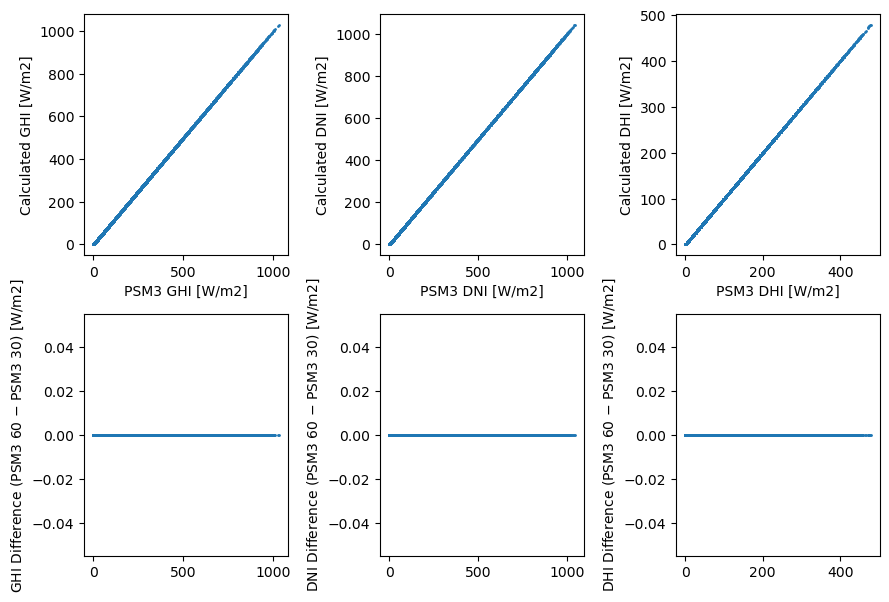

In [11]:
columns = ['GHI', 'DNI', 'DHI']
fig, axes = plt.subplots(2, len(columns), figsize=(9, 6))

for i, column in enumerate(columns):
    x = df_4km60[column]
    y = df_4km30[column][1::2]  # take every other 30-minute value
    axes[0, i].scatter(x, y, s=1)
    axes[0, i].set_xlabel(f'PSM3 {column} [W/m2]')
    axes[0, i].set_ylabel(f'Calculated {column} [W/m2]')

    axes[1, i].scatter(x, x - y, s=1)
    axes[1, i].set_ylabel(f'{column} Difference (PSM3 60 $-$ PSM3 30) [W/m2]')

fig.tight_layout()

In [12]:
%load_ext watermark
%watermark --iversions -u -d -t

Last updated: 2022-09-22 21:27:07

pvlib     : 0.9.3
pandas    : 1.5.0
matplotlib: 3.5.2

